In [17]:
# import wine data
import pandas as pd
df_wine = pd.read_csv('wine.data',header=None)
df_wine.columns=['Class label','Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium','Total phenols','Flavanoids'
                ,'Nonflavanoid phenols','Proanthocynins','Color intensity','Hue','OD280/OD315 of diluted wines',
                'Proline']
df_wine = df_wine[df_wine['Class label'] !=1] # drop 1 class
y = df_wine['Class label'].values
X = df_wine[['Alcohol','OD280/OD315 of diluted wines']].values
# encode the data and split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
y[y==0] = -1
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

In [18]:
import numpy as np

def label_it(D,w):
  """ return the most likely class """
  X,y = D
  cls = np.unique(y)
  cl_w = [sum(w[y==cl]) for cl in cls]
  #v,c = np.unique(y,return_counts=True)
  ind = np.argmax(cl_w)
  return cls[ind]

def split_data(D,split):
  """split the data set"""
  X,y = D
  idx, threshold = split
  idx=int(idx)
    
  idx_l = X[:,idx] <= threshold;
  idx_r = X[:,idx] > threshold;
    
  Xl=X[idx_l,:]
  yl=y[idx_l]
  Xr=X[idx_r,:]
  yr=y[idx_r]

  Dl = (Xl,yl)
  Dr = (Xr,yr)
  return (Dl,Dr,idx_l,idx_r)


def get_thresholds_from_vec(x):
  """ thresholds are the middle points of consecutive unique points """
  return 0.5*np.diff(np.unique(x)) + np.unique(x)[:-1]

def get_threshold_from_mat(X):
  """ call get_thresholds from vec, and zip all the results """
  ns,nf = X.shape
  tmp=[get_thresholds_from_vec(X[:,i]) for i in range(nf)]
  ids = np.concatenate([(i*np.ones(len(item))) for i, item in zip(np.arange(nf),tmp)])
  return [(idx,t) for idx, t in zip(ids,np.concatenate(tmp))]


# class stump
class stump(object):
    """Level one decision tree"""
    def __init__(self,random_state=1):
        self.random_state = random_state
    def flip_coin(self):
        """Randomly return true or false (uniformly)"""
        rgen = np.random.RandomState(self.random_state)
        return rgen.uniform(low=-1,high=1,size=1) >=0
    
    def fit(self,X,y,w):
        sps = get_threshold_from_mat(X)
        P_min = float("inf")
        for sp in sps:
            Dl,Dr,idx_l,idx_r = split_data((X,y),sp)
            wl,wr = w[idx_l],w[idx_r]
            #print(sum(wl),sum(wr),sum(w))
            l_label = label_it(Dl,wl)
            r_label = label_it(Dr,wr)
            
            #print(l_label)
            #print(Dl[1])
            #print(wl,wr)
            
            Pl = sum(wl[Dl[1]!=l_label])
            Pr = sum(wr[Dr[1]!=r_label])
            P = Pl + Pr
            #print(P)
            if P < P_min or (abs(P-P_min)<= 0.001):
                #print('smaller P is found',P)
                P_min = P
                self.split = sp
                self.l_label = l_label
                self.r_label = r_label

        self.P = P_min
        #print(self.split)
        #print(self.l_label)
        #print(self.r_label)
        #print(self.P)
        return self
    
    def predict(self,X):
        if len(X.shape) ==1:
            y_hat = np.where(X[int(self.split[0])] >= self.split[1], self.r_label,self.l_label)
        else:
            y_hat=np.where(X[:,int(self.split[0])] >= self.split[1], self.r_label,self.l_label)
        return  y_hat

In [19]:
# Adaboost from scratch
# Reference: Sergios Theordoridis book
import numpy as np
from Decision_tree import Decision_Tree
#from sklearn.tree import DecisionTreeClassifier

class Adaboost(object):
    
    def __init__(self,N_classifiers=50,max_depth=1,learning_rate=1,random_state=1):
        self.N_classifiers = N_classifiers
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.random_state = random_state
    
    def train(self,X,y):
        N = X.shape[0]
        w = 1/N*np.ones((N)) # initialize the weight
        a = np.zeros((self.N_classifiers,1))
        classifiers = []

        for i in range(self.N_classifiers):
            # compute the optimum theta in the stump by minimizing the weighted error rate P
            tree = Decision_Tree(impurity_fun='entropy',max_depth=self.max_depth)
            #tree = DecisionTreeClassifier(max_depth=self.max_depth,criterion='entropy',random_state=self.random_state)
            tree = stump(random_state=self.random_state)
            #print(w)
            tree.fit(X,y,w)
            #print(tree.root.split)
            #print(tree.root.lchild.split)
            #print(tree.root.rchild.split)


            P = sum(w[y != tree.predict(X)])
            #print(P)
            a[i] = self.learning_rate*np.log((1-P)/P)


            #print(y_hat)
            #print(np.exp(-y*a[i]*tree.predict(X)))
            w = w*np.exp(-y*a[i]*tree.predict(X))
            Z = sum(w)

            
            w = w/Z # normalize the weight 
            #print(w)
            classifiers.append(tree)
        #print(w)
        self.a=a
        self.classifiers = classifiers
        
    def predict(self,x):
        preds=[cl.predict(x) for cl in self.classifiers]
        #print(preds)
        return np.sign(sum(self.a*preds))

    #def predict(self,X):
    #    return np.concatenate([self.predict1(x) for x in X])
    

In [20]:
ada = Adaboost(N_classifiers=500,max_depth=1,learning_rate=.95,random_state=2)
ada.train(X_train,y_train)
#ada.predict(X_test)

In [21]:
sum(ada.predict(X_train)!=y_train)

0

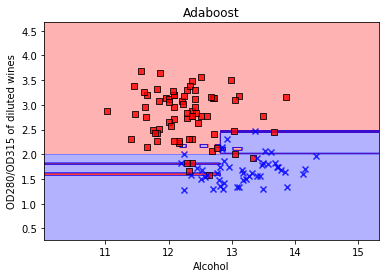

In [22]:
import matplotlib.pyplot as plt
from Perceptron import plot_decision_regions

plt.figure()
plot_decision_regions(X,y,classifier=ada)
plt.title('Adaboost')
plt.xlabel('Alcohol')
plt.ylabel('OD280/OD315 of diluted wines')
plt.show()

In [23]:
ada.a

array([[ 2.26714325],
       [ 2.06506899],
       [ 2.00451208],
       [ 3.61275618],
       [ 3.4955292 ],
       [ 3.41438877],
       [ 3.47184956],
       [ 3.21623833],
       [ 3.14318659],
       [ 3.68660627],
       [ 3.641448  ],
       [ 3.87669581],
       [ 5.11364578],
       [ 6.30805352],
       [ 6.55442423],
       [ 5.90043606],
       [ 5.44183975],
       [ 5.52843597],
       [ 5.06326626],
       [ 5.35780599],
       [ 6.06797197],
       [ 6.0126859 ],
       [ 7.55345153],
       [ 9.80008622],
       [10.01605773],
       [ 9.1038579 ],
       [ 8.28401341],
       [ 7.45561207],
       [ 6.71005086],
       [ 7.06485553],
       [ 6.35946539],
       [ 5.73565518],
       [ 5.51904564],
       [ 5.11879633],
       [ 7.01163527],
       [ 6.49192704],
       [ 5.84273434],
       [ 6.29801181],
       [ 8.23479533],
       [10.60242763],
       [ 8.31557194],
       [ 7.50920033],
       [ 6.76043616],
       [ 5.50455517],
       [ 7.76297507],
       [ 6

In [24]:
rgen.uniform?

Object `rgen.uniform` not found.


In [25]:
ada.classifiers[0].predict(X_test[0,:])

array(1)

In [26]:
X_test.shape

(24, 2)

In [27]:
X_test.shape

(24, 2)

In [28]:
500*24

12000

In [29]:
ada = AdaBoostClassifier

NameError: name 'AdaBoostClassifier' is not defined

In [ ]:
ada = AdaBoostClassifier